## Logistic Regression - Titanic

The titanic dataset is a popular dummy dataset used to learn about logistic regression. It has also been used in a [Kaggle data science competition](https://www.kaggle.com/c/titanic), so you'll also find blogposts exploring all kinds of more advanced concepts that use this dataset too! In this assignment, you'll do a logistic regression to look at the effect of sex and class on survival on the titanic, by computing odds ratios.

adapted from: https://github.com/jstray/lede-algorithms/blob/master/week-3/week-3-2-homework.ipynb

Some references:

- [What are odds vs. probability?](https://towcenter.gitbooks.io/curious-journalist-s-guide-to-data/content/analysis/counting_possible_worlds.html)
- [Investigate.ai on Logistic Regressions](https://investigate.ai/regression/logistic-regression-quickstart/)
- [StatQuest Logistic Regressions Playlist](https://www.youtube.com/watch?v=yIYKR4sgzI8&list=PLblh5JKOoLUKxzEP5HA2d-Li7IJkHfXSe)
- [How do I interpret odds ratios in logistic regression?](https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faq-how-do-i-interpret-odds-ratios-in-logistic-regression/) This one's a little more technical, but has good examples.


In [1]:
import pandas as pd
import numpy as np 
from plotnine import *

### Load the data

Read in the `titanic.csv` data set again.

In [2]:
# Load titanic.csv
df = pd.read_csv('titanic.csv')
df

,pclass,survived,name,age,embarked,home.dest,room,ticket,boat,gender
0,1st,1,"Allen, Miss Elisabeth Walton",29.0000,Southampton,"St Louis, MO",B-5,24160 L221,2,female
1,1st,0,"Allison, Miss Helen Loraine",2.0000,Southampton,"Montreal, PQ / Chesterville, ON",C26,NaN,NaN,female
2,1st,0,"Allison, Mr Hudson Joshua Creighton",30.0000,Southampton,"Montreal, PQ / Chesterville, ON",C26,NaN,-135,male
3,1st,0,"Allison, Mrs Hudson J.C. (Bessie Waldo Daniels)",25.0000,Southampton,"Montreal, PQ / Chesterville, ON",C26,NaN,NaN,female
4,1st,1,"Allison, Master Hudson Trevor",0.9167,Southampton,"Montreal, PQ / Chesterville, ON",C22,NaN,11,male
...,...,...,...,...,...,...,...,...,...,...
1308,3rd,0,"Zakarian, Mr Artun",NaN,NaN,NaN,NaN,NaN,NaN,male
1309,3rd,0,"Zakarian, Mr Maprieder",NaN,NaN,NaN,NaN,NaN,NaN,male
1310,3rd,0,"Zenn, Mr Philip",NaN,NaN,NaN,NaN,NaN,NaN,male
1311,3rd,0,"Zievens, Rene",NaN,NaN,NaN,NaN,NaN,NaN,female


The first thing we need to do is code the pclass and gender variables numerically. Let's use the following scheme:
- pclass: 1,2,3
- gender: 0=male, 1=female, and let's call the column called "female" to remind us which is which

In [3]:
# recode the pclass and gender variables so they are numeric
df['pclass'] = df.pclass.replace({'1st': 1, '2nd': 2, '3rd': 3})
df['female'] = df.gender.replace({'male': 0, 'female': 1})
df.head(3)

,pclass,survived,name,age,embarked,home.dest,room,ticket,boat,gender,female
0,1,1,"Allen, Miss Elisabeth Walton",29.0,Southampton,"St Louis, MO",B-5,24160 L221,2,female,1
1,1,0,"Allison, Miss Helen Loraine",2.0,Southampton,"Montreal, PQ / Chesterville, ON",C26,NaN,NaN,female,1
2,1,0,"Allison, Mr Hudson Joshua Creighton",30.0,Southampton,"Montreal, PQ / Chesterville, ON",C26,NaN,-135,male,0


### 1. Exploratory data analysis

In [4]:
df.head()

,pclass,survived,name,age,embarked,home.dest,room,ticket,boat,gender,female
0,1,1,"Allen, Miss Elisabeth Walton",29.0000,Southampton,"St Louis, MO",B-5,24160 L221,2,female,1
1,1,0,"Allison, Miss Helen Loraine",2.0000,Southampton,"Montreal, PQ / Chesterville, ON",C26,NaN,NaN,female,1
2,1,0,"Allison, Mr Hudson Joshua Creighton",30.0000,Southampton,"Montreal, PQ / Chesterville, ON",C26,NaN,-135,male,0
3,1,0,"Allison, Mrs Hudson J.C. (Bessie Waldo Daniels)",25.0000,Southampton,"Montreal, PQ / Chesterville, ON",C26,NaN,NaN,female,1
4,1,1,"Allison, Master Hudson Trevor",0.9167,Southampton,"Montreal, PQ / Chesterville, ON",C22,NaN,11,male,0


In [5]:
# First, let's do some descriptive stats
# How many men and women were travelling on the titanic?
df.gender.value_counts()


male      850
female    463
Name: gender, dtype: int64

In [6]:
# How many people were travelling in each class?
df.pclass.value_counts()

3    711
1    322
2    280
Name: pclass, dtype: int64

In [7]:
piv_fem = df.pivot_table(index='survived', columns='female', aggfunc='count', values='name')
display(piv_fem)
pct_fem = piv_fem.apply(lambda x: x/sum(x)).round(2)
display(pct_fem)
# only 16.7% of men survived in comparison to 66.3% of women

female,0,1
survived,,
0,708,156
1,142,307


female,0,1
survived,,
0,0.83,0.34
1,0.17,0.66


In [8]:
piv_class = df.pivot_table(index='survived', columns='pclass', aggfunc='count', values='name')
display(piv_class)
pct_class = piv_class.apply(lambda x: x/sum(x)).round(3)
display(pct_class)
# men and women mixed, 60% of those in first class survived, 42% of those in 2nd class 
# and only 19% of those embarked on 3rd class

pclass,1,2,3
survived,,,
0,129,161,574
1,193,119,137


pclass,1,2,3
survived,,,
0,0.401,0.575,0.807
1,0.599,0.425,0.193


In [9]:
# What share of each survived?
piv = df.pivot_table(index='survived', columns=(['female', 'pclass']), aggfunc='count', values='name')
display(piv)

pct_survived = piv.apply(lambda x: x/sum(x)).round(2)
display(pct_survived)

female      0              1         
pclass      1    2    3    1   2    3
survived                             
0         120  148  440    9  13  134
1          59   25   58  134  94   79

female       0                 1            
pclass       1     2     3     1     2     3
survived                                    
0         0.67  0.86  0.88  0.06  0.12  0.63
1         0.33  0.14  0.12  0.94  0.88  0.37

In [10]:
# For women, 94% in first class survived, 88% in 2nd class and 37% in 3rd class
# For men, 33% of those in first class survived, while there was only a 14% and 12% 
## survival rate for 2nd and 3rd class, respectively (and assuming an equal difference among classes)

### 2. Logistic regression with one variable at a time

First, do a logistic regression of the `female` variable alone to predict the probability of survival. Below is some code that will help you plot the result.

In [11]:
# Step 1: Run a logistic regression on one variable and see the summary of the output
# hint: 
# https://investigate.ai/regression/logistic-regression-quickstart/#Performing-a-regression

import statsmodels.formula.api as smf
model = smf.logit(formula='survived ~ female', data=df)
results = model.fit()
results.summary()



# because the coeficient is positive the chances of survival increase, 
# and p>z is small so it's a significant correlation

Optimization terminated successfully.
         Current function value: 0.517411
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               survived   No. Observations:                 1313
Model:                          Logit   Df Residuals:                     1311
Method:                           MLE   Df Model:                            1
Date:                Thu, 07 Apr 2022   Pseudo R-squ.:                  0.1945
Time:                        09:23:18   Log-Likelihood:                -679.36
converged:                       True   LL-Null:                       -843.38
Covariance Type:            nonrobust   LLR p-value:                 2.572e-73
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.6066      0.092    -17.473      0.000      -1.787      -1.426
female         2.2836      0.135     16.963      0.000       2.020       2.547
==============================================================================
"""

In [12]:
# Step 2: analyze the dataframe with predicted values
# hint: 
# you'll need to create a new column on df and use results.predict() to assign it values
# https://investigate.ai/regression/logistic-regression-quickstart/#Making-predictions

df['prediction'] = results.predict()
df



#the fact of being women gave them 66% chances of survival, according to our model 
##(exact thing as the percentage we got from our pivot table as we only have one variable)

,pclass,survived,name,age,embarked,home.dest,room,ticket,boat,gender,female,prediction
0,1,1,"Allen, Miss Elisabeth Walton",29.0000,Southampton,"St Louis, MO",B-5,24160 L221,2,female,1,0.663067
1,1,0,"Allison, Miss Helen Loraine",2.0000,Southampton,"Montreal, PQ / Chesterville, ON",C26,NaN,NaN,female,1,0.663067
2,1,0,"Allison, Mr Hudson Joshua Creighton",30.0000,Southampton,"Montreal, PQ / Chesterville, ON",C26,NaN,-135,male,0,0.167059
3,1,0,"Allison, Mrs Hudson J.C. (Bessie Waldo Daniels)",25.0000,Southampton,"Montreal, PQ / Chesterville, ON",C26,NaN,NaN,female,1,0.663067
4,1,1,"Allison, Master Hudson Trevor",0.9167,Southampton,"Montreal, PQ / Chesterville, ON",C22,NaN,11,male,0,0.167059
...,...,...,...,...,...,...,...,...,...,...,...,...
1308,3,0,"Zakarian, Mr Artun",NaN,NaN,NaN,NaN,NaN,NaN,male,0,0.167059
1309,3,0,"Zakarian, Mr Maprieder",NaN,NaN,NaN,NaN,NaN,NaN,male,0,0.167059
1310,3,0,"Zenn, Mr Philip",NaN,NaN,NaN,NaN,NaN,NaN,male,0,0.167059
1311,3,0,"Zievens, Rene",NaN,NaN,NaN,NaN,NaN,NaN,female,1,0.663067


In [13]:
df.prediction.unique() 
## distinction btw male and female

array([0.66306695, 0.16705882])

In [14]:
# Step 3: What is the odds ratio of on the gender variable alone?

# hint: 
# https://investigate.ai/regression/logistic-regression-quickstart/#Converting-coefficient-to-odds
## in order to make sense of the coefficients, you'll need to exponentiate them
## that way we turn the coefficients into odds ratios


coefs = pd.DataFrame({
    'coef': results.params.values,
    'odds ratio': np.exp(results.params.values),
    'pvalue': results.pvalues,
    'name': results.params.index
})
coefs


# the coeficient is again positive, so the chances of survival are higher
## the odds ratio tells us that if you were a woman in the Titanic your odds
## of survival would have been over nine times higher

,coef,odds ratio,pvalue,name
Intercept,-1.606617,0.200565,2.306853e-68,Intercept
female,2.283609,9.812026,1.529597e-64,female


Now, try the same thing but with the `pclass` variable

In [15]:
# Step 1: Run a logistic regression on one variable and see the summary of the output

# hint: 
# https://investigate.ai/regression/logistic-regression-quickstart/#Performing-a-regression
import statsmodels.formula.api as smf
model = smf.logit(formula='survived ~ pclass', data=df)
results = model.fit()
results.summary()



## the coeficient is negative, so the chances of survival decrease as the class worsen
## and it is significant

Optimization terminated successfully.
         Current function value: 0.576759
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               survived   No. Observations:                 1313
Model:                          Logit   Df Residuals:                     1311
Method:                           MLE   Df Model:                            1
Date:                Thu, 07 Apr 2022   Pseudo R-squ.:                  0.1021
Time:                        09:23:18   Log-Likelihood:                -757.28
converged:                       True   LL-Null:                       -843.38
Covariance Type:            nonrobust   LLR p-value:                 2.459e-39
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.3996      0.170      8.236      0.000       1.067       1.733
pclass        -0.9285      0.074    -12.611      0.000      -1.073      -0.784
==============================================================================
"""

In [16]:
# Step 2: analyze the dataframe with predicted values

# hint: 
# you'll need to create a new column on df and use results.predict() to assign it values
# https://investigate.ai/regression/logistic-regression-quickstart/#Making-predictions

df['prediction'] = results.predict()
df


# while having a 1st class ticket gave us a 61% chance of survival
## a second class ticket gave us a 38% and a third class ticket the lowest with 20% chances of survival
## same as our pivot table

,pclass,survived,name,age,embarked,home.dest,room,ticket,boat,gender,female,prediction
0,1,1,"Allen, Miss Elisabeth Walton",29.0000,Southampton,"St Louis, MO",B-5,24160 L221,2,female,1,0.615642
1,1,0,"Allison, Miss Helen Loraine",2.0000,Southampton,"Montreal, PQ / Chesterville, ON",C26,NaN,NaN,female,1,0.615642
2,1,0,"Allison, Mr Hudson Joshua Creighton",30.0000,Southampton,"Montreal, PQ / Chesterville, ON",C26,NaN,-135,male,0,0.615642
3,1,0,"Allison, Mrs Hudson J.C. (Bessie Waldo Daniels)",25.0000,Southampton,"Montreal, PQ / Chesterville, ON",C26,NaN,NaN,female,1,0.615642
4,1,1,"Allison, Master Hudson Trevor",0.9167,Southampton,"Montreal, PQ / Chesterville, ON",C22,NaN,11,male,0,0.615642
...,...,...,...,...,...,...,...,...,...,...,...,...
1308,3,0,"Zakarian, Mr Artun",NaN,NaN,NaN,NaN,NaN,NaN,male,0,0.200052
1309,3,0,"Zakarian, Mr Maprieder",NaN,NaN,NaN,NaN,NaN,NaN,male,0,0.200052
1310,3,0,"Zenn, Mr Philip",NaN,NaN,NaN,NaN,NaN,NaN,male,0,0.200052
1311,3,0,"Zievens, Rene",NaN,NaN,NaN,NaN,NaN,NaN,female,1,0.200052


In [17]:
# Step 3: What is the odds ratio of on the pclass variable alone?

# hint: in order to make sense of the coefficients, you'll need to exponentiate them
# that turns the coefficients into odds ratios
# https://investigate.ai/regression/logistic-regression-quickstart/#Converting-coefficient-to-odds

coefs = pd.DataFrame({
    'coef': results.params.values,
    'odds ratio': np.exp(results.params.values),
    'pvalue': results.pvalues,
    'name': results.params.index
})
coefs




## the cof. is negative (a negative correlation), so if the class worsens the chances of survival also decrease
### your odds of survival would have been 0.4 times lower from 1st class to 2nd class, and from 2nd to 3rd

,coef,odds ratio,pvalue,name
Intercept,1.399625,4.053680,1.778696e-16,Intercept
pclass,-0.928532,0.395133,1.832570e-36,pclass


**Bonus** 🤖 - Writing clean/DRY code

DRY stands for "Don't Repeat Yourself". This is a good principle of writing clean code. Instead of copy/pasting code multiple times (which can lead to errors if you fix one copy but not the other), you can write DRY code by wrapping any chunk of code you plan to repeat in a function. As a bonus on this section, re-write the code above as a function and run that function once on `female` and once on `pclass`.

### 3. Looking at two variables at a time

We know from the earlier assignment that class also affects survival, so let's add that to our model. Compute a logistic regression on the variables `pclass` and `female`.

In [18]:
import statsmodels.formula.api as smf
model = smf.logit(formula='survived ~ female + pclass', data=df)
results = model.fit()
results.summary()

## less percentage due to chance, a more significant pseudo R-squ
## p value also significant

Optimization terminated successfully.
         Current function value: 0.457739
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               survived   No. Observations:                 1313
Model:                          Logit   Df Residuals:                     1310
Method:                           MLE   Df Model:                            2
Date:                Thu, 07 Apr 2022   Pseudo R-squ.:                  0.2874
Time:                        09:23:18   Log-Likelihood:                -601.01
converged:                       True   LL-Null:                       -843.38
Covariance Type:            nonrobust   LLR p-value:                5.504e-106
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6210      0.196      3.173      0.002       0.237       1.005
female         2.4285      0.151     16.117      0.000       2.133       2.724
pclass        -1.0373      0.088    -11.787      0.000      -1.210      -0.865
==============================================================================
"""

In [19]:
df['prediction'] = results.predict()
df

## 88% chances of survival if you were a woman in 1st class
## versus 40% odss of survival for men in 1st class 
## -- 0.07% for men in 3rd versus 0.48% for the female counterpart

,pclass,survived,name,age,embarked,home.dest,room,ticket,boat,gender,female,prediction
0,1,1,"Allen, Miss Elisabeth Walton",29.0000,Southampton,"St Louis, MO",B-5,24160 L221,2,female,1,0.882065
1,1,0,"Allison, Miss Helen Loraine",2.0000,Southampton,"Montreal, PQ / Chesterville, ON",C26,NaN,NaN,female,1,0.882065
2,1,0,"Allison, Mr Hudson Joshua Creighton",30.0000,Southampton,"Montreal, PQ / Chesterville, ON",C26,NaN,-135,male,0,0.397390
3,1,0,"Allison, Mrs Hudson J.C. (Bessie Waldo Daniels)",25.0000,Southampton,"Montreal, PQ / Chesterville, ON",C26,NaN,NaN,female,1,0.882065
4,1,1,"Allison, Master Hudson Trevor",0.9167,Southampton,"Montreal, PQ / Chesterville, ON",C22,NaN,11,male,0,0.397390
...,...,...,...,...,...,...,...,...,...,...,...,...
1308,3,0,"Zakarian, Mr Artun",NaN,NaN,NaN,NaN,NaN,NaN,male,0,0.076494
1309,3,0,"Zakarian, Mr Maprieder",NaN,NaN,NaN,NaN,NaN,NaN,male,0,0.076494
1310,3,0,"Zenn, Mr Philip",NaN,NaN,NaN,NaN,NaN,NaN,male,0,0.076494
1311,3,0,"Zievens, Rene",NaN,NaN,NaN,NaN,NaN,NaN,female,1,0.484385


In [20]:
# Step 3: What is the odds ratio of on the gender variable?
## the odds of survival are 11 times higher for women

coefs = pd.DataFrame({
    'coef': results.params.values,
    'odds ratio': np.exp(results.params.values),
    'pvalue': results.pvalues,
    'name': results.params.index
})
coefs


,coef,odds ratio,pvalue,name
Intercept,0.620955,1.860705,1.510011e-03,Intercept
female,2.428483,11.341669,1.949881e-58,female
pclass,-1.037306,0.354408,4.556499e-32,pclass


### 4. What does this mean

What is the odds ratio on the `pclass` variable? What happens to the odds of survival when we move from 1st to 2nd or from 2nd to 3rd class?


👉 <b>If we move from a higher class to the next one below, the odds of survival are 0.35 times lower in each jump

### 5. Bonus - Age

Does the age of a passenger impact their chances of survival?

In [21]:
df

,pclass,survived,name,age,embarked,home.dest,room,ticket,boat,gender,female,prediction
0,1,1,"Allen, Miss Elisabeth Walton",29.0000,Southampton,"St Louis, MO",B-5,24160 L221,2,female,1,0.882065
1,1,0,"Allison, Miss Helen Loraine",2.0000,Southampton,"Montreal, PQ / Chesterville, ON",C26,NaN,NaN,female,1,0.882065
2,1,0,"Allison, Mr Hudson Joshua Creighton",30.0000,Southampton,"Montreal, PQ / Chesterville, ON",C26,NaN,-135,male,0,0.397390
3,1,0,"Allison, Mrs Hudson J.C. (Bessie Waldo Daniels)",25.0000,Southampton,"Montreal, PQ / Chesterville, ON",C26,NaN,NaN,female,1,0.882065
4,1,1,"Allison, Master Hudson Trevor",0.9167,Southampton,"Montreal, PQ / Chesterville, ON",C22,NaN,11,male,0,0.397390
...,...,...,...,...,...,...,...,...,...,...,...,...
1308,3,0,"Zakarian, Mr Artun",NaN,NaN,NaN,NaN,NaN,NaN,male,0,0.076494
1309,3,0,"Zakarian, Mr Maprieder",NaN,NaN,NaN,NaN,NaN,NaN,male,0,0.076494
1310,3,0,"Zenn, Mr Philip",NaN,NaN,NaN,NaN,NaN,NaN,male,0,0.076494
1311,3,0,"Zievens, Rene",NaN,NaN,NaN,NaN,NaN,NaN,female,1,0.484385


In [116]:
df.age.describe()


# we are missing more than half of the values
## we take into account that in 1912 the life expectancy in the US apparently was ~52 years
## we try to be aware that kids and women were taken first into lifeboats

count    633.000000
mean      31.194181
std       14.747525
min        0.166700
25%       21.000000
50%       30.000000
75%       41.000000
max       71.000000
Name: age, dtype: float64

In [117]:
## we get rid of NaN values in the age column
df = df[df['age'].notna()]

<AxesSubplot:>

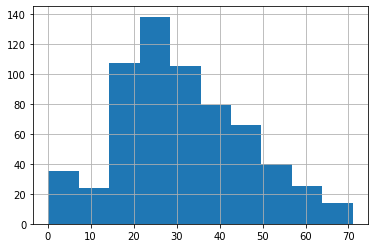

In [118]:
df.age.hist()

In [119]:
df_elder = df.age[df.age >= 40]
df_elder.count()

174

In [120]:
df_adult = df.age[(df.age >= 18) & (df.age < 40)]
df_adult.count()

377

In [121]:
df_teen = df.age[(df.age >= 10) & (df.age < 18)]
df_teen.count()

36

In [122]:
df_kid = df.age[df.age < 10]
df_kid.count()

46

In [135]:
# # we recode the age variable to create four numeric main groups
criteria = [df['age'].between(0, 9), df['age'].between(10, 17), df['age'].between(18, 39), df['age'].between(40, 71)]
values = [1, 2, 3, 4]

df['age_group'] = np.select(criteria, values, 0)
df

,pclass,survived,name,age,embarked,home.dest,room,ticket,boat,gender,female,prediction,age_group
0,1,1,"Allen, Miss Elisabeth Walton",29.0000,Southampton,"St Louis, MO",B-5,24160 L221,2,female,1,0.951249,3
1,1,0,"Allison, Miss Helen Loraine",2.0000,Southampton,"Montreal, PQ / Chesterville, ON",C26,NaN,NaN,female,1,0.992117,1
2,1,0,"Allison, Mr Hudson Joshua Creighton",30.0000,Southampton,"Montreal, PQ / Chesterville, ON",C26,NaN,-135,male,0,0.466226,3
3,1,0,"Allison, Mrs Hudson J.C. (Bessie Waldo Daniels)",25.0000,Southampton,"Montreal, PQ / Chesterville, ON",C26,NaN,NaN,female,1,0.951249,3
4,1,1,"Allison, Master Hudson Trevor",0.9167,Southampton,"Montreal, PQ / Chesterville, ON",C22,NaN,11,male,0,0.849259,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
833,3,0,"Gronnestad, Mr Daniel Danielsen",32.0000,Southampton,"Foresvik, Norway Portland, ND",NaN,NaN,NaN,male,0,0.053947,3
835,3,0,"Gustafsson, Mr Alfred Ossian",20.0000,Southampton,"Waukegan, Chicago, IL",NaN,NaN,NaN,male,0,0.053947,3
836,3,0,"Gustafsson, Mr Anders Vilhelm",37.0000,Southampton,"Ruotsinphytaa, Finland New York, NY",NaN,NaN,NaN,male,0,0.053947,3
837,3,0,"Gustafsson, Mr Johan Birger",28.0000,Southampton,"Ruotsinphytaa, Finland New York, NY",NaN,NaN,NaN,male,0,0.053947,3


In [150]:
# the pseudo R-sq was too small if we only looked into age without considering also gender (and women were given priority)
import statsmodels.formula.api as smf
model = smf.logit(formula='survived ~ age_group + female + pclass', data=df)
results = model.fit()
results.summary()


Optimization terminated successfully.
         Current function value: 0.422302
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               survived   No. Observations:                  633
Model:                          Logit   Df Residuals:                      629
Method:                           MLE   Df Model:                            3
Date:                Thu, 07 Apr 2022   Pseudo R-squ.:                  0.3852
Time:                        10:25:49   Log-Likelihood:                -267.32
converged:                       True   LL-Null:                       -434.77
Covariance Type:            nonrobust   LLR p-value:                 2.761e-72
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.0253      0.657      6.129      0.000       2.738       5.313
age_group     -0.9321      0.154     -6.066      0.000      -1.233      -0.631
female         3.1064      0.243     12.768      0.000       2.630       3.583
pclass        -1.3645      0.164     -8.327      0.000      -1.686      -1.043
==============================================================================
"""

In [155]:
df['prediction'] = results.predict()
df.tail(50)




# According to our model, female babies in 1st class had a 99% survival rate, followed by kids and young women (95%).
# Male kids in 1st class had a survival rate of 69%; 46% in the case of male adults.
# Elder in 1st class, women had a survival rate of 88% vs 24 for old men

# On a different spectrum, among those on 3rd class, young women had a survival rate of 56% in comparison to 0.05% for men
# 0.02% for elder male in 3rd class versus 0.33% for elder women on the same class

,pclass,survived,name,age,embarked,home.dest,room,ticket,boat,gender,female,prediction,age_group
764,3,0,"Delalic, Mr Regyo",25.0,Southampton,NaN,NaN,NaN,NaN,male,0,0.053947,3
765,3,1,"De Messemaeker, Mr William Joseph",36.0,Southampton,"Tampico, MT",NaN,NaN,15,male,0,0.053947,3
766,3,1,"De Messemaeker, Mrs William Joseph (Anna)",36.0,Southampton,"Tampico, MT",NaN,NaN,13,female,1,0.560221,3
767,3,1,"De Mulder, Mr Theo",30.0,Southampton,"Belgium Detroit, MI",NaN,NaN,NaN,male,0,0.053947,3
769,3,0,"Dennis, Mr Samuel",23.0,Southampton,NaN,NaN,NaN,NaN,male,0,0.053947,3
770,3,0,"Dennis, Mr William",26.0,Southampton,NaN,NaN,NaN,NaN,male,0,0.053947,3
771,3,1,"Devaney, Miss Margaret",19.0,Queenstown,"Kilmacowen, Co Sligo, Ireland New York, NY",NaN,NaN,C,female,1,0.560221,3
772,3,0,"Dewan, Mr Frank",65.0,Queenstown,NaN,NaN,NaN,NaN,male,0,0.021960,4
774,3,0,"Dimic, Mr Jovan",42.0,Southampton,NaN,NaN,NaN,NaN,male,0,0.021960,4
775,3,0,"Dintcheff, Mr Valtcho",43.0,Southampton,NaN,NaN,NaN,NaN,male,0,0.021960,4


In [157]:
coefs = pd.DataFrame({
    'coef': results.params.values,
    'odds ratio': np.exp(results.params.values),
    'pvalue': results.pvalues,
    'name': results.params.index
})
coefs

## the effect of gender is four times (?) than the effect of class (according to the -coef)
## the odds ratios says that women had a survival rate 22 times higher (!!!), which makes me think that our model
## gave gender too much weight, and that's way the predicted survival rate seems just too high for women
## Is our model wrong?

,coef,odds ratio,pvalue,name
Intercept,4.025344,55.999553,8.840106e-10,Intercept
age_group,-0.932050,0.393746,1.307329e-09,age_group
female,3.106356,22.339485,2.463474e-37,female
pclass,-1.364496,0.255509,8.294752e-17,pclass
